In [323]:
import featurization
import helpers
import model

import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [165]:
from shapely.geometry import Polygon
import scipy.stats as scs

In [77]:
geodf = featurization.all_featurization("all-sc-bike-data-1101.csv")

Dropping 1 entries where end time was before start time


In [8]:
X = geodf[['day_of_week', 'time_of_day_start', 'ZONING', 'pop_density', 'GEOID_Data']]
X = pd.get_dummies(X, columns=['ZONING'], prefix='zone')
X = pd.get_dummies(X, columns=['GEOID_Data'], prefix='blockgroup')
y = np.log(geodf['idle_time'].dt.seconds)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
gbmodel = GradientBoostingRegressor()
gbmodel.fit(X_train, y_train)
print(gbmodel.score(X_train, y_train))
print(gbmodel.score(X_test, y_test))

0.24655007469243306
0.17488943505100552


In [78]:
points = geodf['geolocation']

In [67]:
buffs = points.buffer(500)

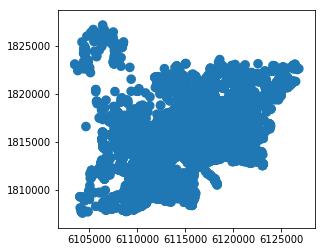

In [68]:
buffs.plot()

In [69]:
buffs.head()

58     POLYGON ((6114079.644399152 1821504.33065657, ...
59     POLYGON ((6114077.201418149 1821533.502997679,...
137    POLYGON ((6112725.585502468 1821056.805009632,...
136    POLYGON ((6112579.320061087 1821044.644424588,...
256    POLYGON ((6114054.37488384 1821566.651068939, ...
dtype: object

In [70]:
f = lambda x:np.sum(g['geolocation'].intersects(x))
points_in_buffs = buffs.apply(f)

In [75]:
points_in_buffs.describe()

count    7098.000000
mean       70.482671
std        72.222093
min         1.000000
25%        21.000000
50%        41.000000
75%        88.000000
max       335.000000
dtype: float64

In [159]:
one_bike = geodf.iloc[1025]

In [160]:
one_point = one_bike['geolocation']

In [161]:
one_buff = geopandas.GeoSeries(one_point).buffer(1000)

In [162]:
points_in_buff = geodf[geodf.intersects(one_buff.iloc[0])]
points = points_in_buff[(points_in_buff['day_of_week'] == one_bike['day_of_week']) & (points_in_buff['time_of_day_start'] == one_bike['time_of_day_start'])]

In [163]:
len(points)

18

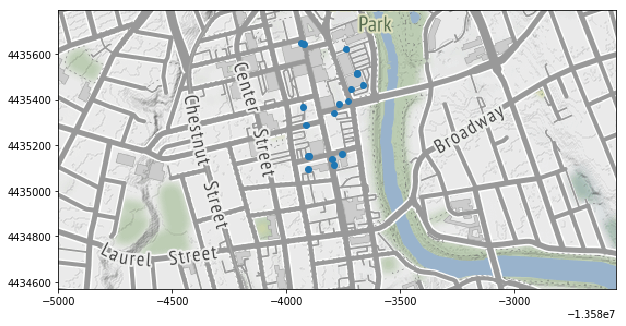

In [164]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
helpers.map_bikes(ax, points)

prior_prob_beta = parameter of the exponential distribution fit to that region of the city (a rough estimate starting point)
update using all observations within the same hour, on a weekday/weekend, within some fairly small radius 
- find the prob of each of these observations for a range of beta_hyp



when a new point comes in, find all points in a 1000ft radius on same day of week and same hour of day, and use those to update the prior

In [229]:
#bike_idle_times = geodf[geodf['GEOID_Data'] == one_bike['GEOID_Data']]['idle_hours']
#hypothesis = np.linspace(0.1, 10, 100)
#likelihood0 = []
#for beta0 in hyp_betas:
#    likelihood0.append(np.prod(scs.expon(scale=beta0).pdf(bike_idle_times)))
##does not work - too many data points means every beta is 0                

In [237]:
def get_beta_for_blockgroups(geodf):
    '''
    Divides all idle bike observations by blockgroup (proxy for regions of the city), then fits an exponential distribution to each grouping.
    
    Input: Dataframe (geopandas or pandas)
    Output: Dictionary 
            keys: blockgroup name (from GEOID_Data column of dataframe), 
            values: estimated beta value for an exponential distribution of idle_times in that blockgroup
    '''
    
    blockgroups = geodf.GEOID_Data.unique()
    beta_all = scs.expon.fit(geodf['idle_hours'])[1]

    beta_by_bg = {}
    for bg in blockgroups:
        bikes_in_bg = geodf[geodf.GEOID_Data == bg]
        if len(bikes_in_bg) > 10:
            beta_bg = scs.expon.fit(bikes_in_bg['idle_hours'])[1]
            beta_by_bg[bg] = beta_bg
        else:
            beta_by_bg[bg] = beta_all
            
    return beta_by_bg

In [200]:
def get_nearest_neighbor_bikes(one_bike, geodf):
    '''
    Finds all bikes within 1000ft on same day of week and hour of day.
    
    Inputs: bike of interest, geopandas dataframe
    Output: geopandas dataframe
    '''
    
    one_point = one_bike['geolocation']
    buff = geopandas.GeoSeries(one_point).buffer(1000)
    points_in_buff = geodf[geodf.intersects(buff.iloc[0])]
    points = points_in_buff[(points_in_buff['day_of_week'] == one_bike['day_of_week']) & (points_in_buff['time_of_day_start'] == one_bike['time_of_day_start'])]
    
    return points

In [374]:
def bayesian_update(prior_beta_dist, hyp_betas, datapoints):
    '''
    Updates a prior distribution of eponential beta values based on more specific bike idle time observations.
    
    Inputs: prior_beta_dist(scipy.stats rv_frozen object), hyp_betas(array-like), datapoints(dataframe)
    Output: posterior_beta_dist(numpy array)
    '''
    if len(datapoints) == 0:
        #in the case where there are no similar datapoints to update the distribution with, just return the 
        #prior distribution in array format (aka the distribution that's been fit to the entire blockgroup)
        return prior_beta_dist.pdf(hyp_betas)
    
    posterior_beta_dist = []
    for beta0 in hyp_betas:
        likelihood = np.prod(scs.expon(scale=beta0).pdf(datapoints['idle_hours']))
        posterior_beta_dist.append(likelihood*prior_beta_dist.pdf(beta0))
    posterior_beta_dist = np.array(posterior_beta_dist)
    posterior_beta_dist /= posterior_beta_dist.sum()
    return posterior_beta_dist

In [238]:
beta_by_bg = get_beta_for_blockgroups(geodf)

In [373]:
beta_by_bg

{'15000US060871003001': 2.7807110091743117,
 '15000US060871007002': 1.1247683835438935,
 '15000US060871010001': 0.8462587790383577,
 '15000US060871010002': 1.075215277777778,
 '15000US060871006001': 1.917215145081387,
 '15000US060871012001': 1.4259572285353537,
 '15000US060871006002': 1.7888013285024156,
 '15000US060871010005': 1.278258807588076,
 '15000US060871010003': 1.2331604938271603,
 '15000US060871011005': 2.4392536047497884,
 '15000US060871008003': 3.685840149965917,
 '15000US060871007001': 2.625252192982457,
 '15000US060871010006': 1.7059339774557165,
 '15000US060871008006': 4.662452718676122,
 '15000US060871008005': 4.693621399176954,
 '15000US060871008002': 3.4302439024390243,
 '15000US060871010004': 1.7793518518518519,
 '15000US060871008004': 3.720415368639668,
 '15000US060871009002': 3.308116096866097,
 '15000US060871009001': 6.496535087719297,
 '15000US060871010007': 2.1767866941015095,
 '15000US060871002006': 4.471119791666667,
 '15000US060871008001': 2.66978199718706,
 

In [369]:
index=10948
one_bike = geodf.loc[index]

#because I'm just pulling random points out of dataset, need to drop the point I'm using
points = get_nearest_neighbor_bikes(one_bike, geodf.drop(index=index))

beta = beta_by_bg[one_bike['GEOID_Data']]
prior_beta_dist = scs.norm(beta, 2)
hyp_betas = np.linspace(0.001, 8, 100)

post_beta_dist = bayesian_update(prior_beta_dist, hyp_betas, points)

In [372]:
type(prior_beta_dist)

scipy.stats._distn_infrastructure.rv_frozen

actual: 2.562777777777778
posterior: 3.3945151515151513
prior: 3.3611096096096102


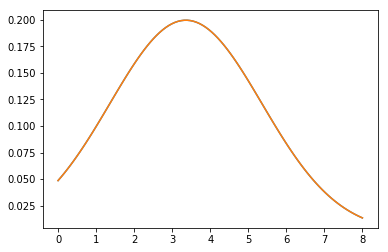

In [370]:
print("actual: {}".format(one_bike['idle_hours']))
print("posterior: {}".format(hyp_betas[np.argmax(post_beta_dist)]))
print("prior: {}".format(beta))
plt.plot(hyp_betas, post_beta_dist)
plt.plot(hyp_betas, prior_beta_dist.pdf(hyp_betas))

In [ ]:
676

In [207]:
hypothesis = np.linspace(0.1, 20)
likelihood = [ scs.expon( scale=hyp ).pdf( points['idle_hours'] ).prod() for hyp in hypothesis]

In [168]:
bg1 = geodf[geodf.GEOID_Data == '15000US060871003001']

In [171]:
bg1_idle_hours = bg1['idle_hours']

In [180]:
beta = scs.expon.fit(bg1_idle_hours)[1]

In [182]:
expon_dist = scs.expon(scale=beta)
x = np.linspace(0,60)
p_x = expon_dist.pdf(x)

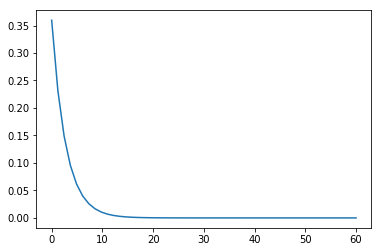

In [184]:
plt.plot(x, p_x)

(array([311.,  49.,  29.,   8.,   5.,   8.,   7.,   6.,   7.,   6.]),
 array([ 0.        ,  2.37130556,  4.74261111,  7.11391667,  9.48522222,
        11.85652778, 14.22783333, 16.59913889, 18.97044444, 21.34175   ,
        23.71305556]),
 <a list of 10 Patch objects>)

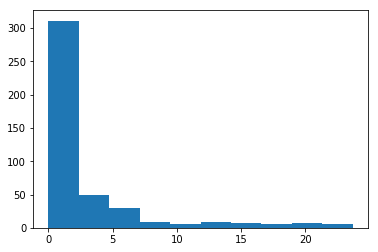

In [185]:
plt.hist(bg1_idle_hours)

In [325]:
beta_priors = model.get_beta_for_blockgroups(geodf)

In [326]:
X = geodf
y = geodf['idle_hours']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [355]:
neighbors = X_test.apply(model.get_nearest_neighbor_bikes, axis=1, args=(X_train,))

In [375]:
def apply_bayesian_updates(one_bike, geodf):
    points = get_nearest_neighbor_bikes(one_bike, geodf)

    beta = beta_by_bg[one_bike['GEOID_Data']]
    prior_beta_dist = scs.norm(beta, 2)
    hyp_betas = np.linspace(0.001, 8, 100)

    post_beta_dist = bayesian_update(prior_beta_dist, hyp_betas, points)
    beta = hyp_betas[np.argmax(post_beta_dist)]
    
    return post_beta_dist, beta

In [415]:
beta_dists = X_test.apply(apply_bayesian_updates, axis=1, args=(X_train,))

In [423]:
betas = pd.DataFrame(beta_dists.tolist())
betas.columns=['beta_dist', 'most_likely_beta']

In [417]:
type(betas)

pandas.core.frame.DataFrame

In [ ]:
pd.concat()

In [424]:
betas['priority'] = betas['most_likely_beta'].argsort()

In [425]:
betas.head()

,beta_dist,most_likely_beta,priority
0,"[0.0, 0.0010269340275014423, 0.067250279749140...",0.324192,576
1,"[0.048636656308800985, 0.052009893991001796, 0...",3.394515,1136
2,"[0.12605073755898671, 0.13091850676869676, 0.1...",1.940152,614
3,"[0.13396082829226091, 0.13876480209725872, 0.1...",1.778556,143
4,"[0.08188942786700741, 0.08635458542264103, 0.0...",2.667333,124


In [422]:
betas = betas.sort_values('most_likely_beta', axis=0, ascending=False)

In [348]:
model.get_nearest_neighbor_bikes(X_test.iloc[0], X_train)

['bike_21402', 'bike_23270', 'bike_21272', 'bike_21180']

In [347]:
type(X_test.iloc[0])

pandas.core.series.Series